In [13]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

# **Обучение нейрона выполнению функции логического "И"**

In [14]:
X = tf.constant([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=tf.float32) # входные данные x1 и x2 (признаки, характеризующие объект)
Y = tf.constant([[0], [0], [0], [1]], dtype=tf.float32) # желаемый выход (метки классов для каждого объекта)

In [15]:
# Вспомогательная функция для отрисовки границы решения
def plot_decision_boundary(model, X, y):

  # Определются границы рассматриваемого пространства (минимальный и максимальный x и y) и создаётся его сетка meshgrid
  X = X.numpy()
  y = y.numpy()
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx1, xx2 = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

  # Создаются входные сигналы X (мы собираемся предсказывать значения по всей сетке рассматриваемого пространства)
  x_in = np.c_[xx1.ravel(), xx2.ravel()] # соединяем 2D массивы вместе: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Осуществляется предсказание для входных сигналов X
  y_pred = model.predict(x_in, batch_size=1024)
  y_pred = np.round(np.max(y_pred, axis=-1)).reshape(xx1.shape) # reshape необходим поскольку результатом будет 1D вектор, а необходим 2D, как у xx1

  # Визуализация границ решения
  plt.contourf(xx1, xx2, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.pause(0.01)

# Вспомогательный колбэк для отрисовки границы решений каждые 100 эпох и остановки обучения если точность достигла 1.0
class PlotAndStopCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0:  # Отрисовываем каждые 100 эпох
            print(f"Epoch {epoch + 1}")
            plot_decision_boundary(self.model, X, Y)

        if logs.get('accuracy') == 1.0:  # Остановка, если точность достигла 1.0
            print(f"\nStopping training at epoch {epoch + 1} as accuracy reached 1.0")
            plot_decision_boundary(self.model, X, Y)
            self.model.stop_training = True

In [16]:
###### Основной код ######

def createModel(input_shape):
  input_x = Input(shape=(input_shape, )) # для создания модели необходимо предопределить вход и размерность входных данных input_shape
  z = Dense(1)(input_x) # создаём 1 нейрон и передаём в него входные сигналы input_x
  p = Activation('sigmoid')(z) # результат обработки нейроном входных сигналов z поступает в сигмоидальную функцию активации, которая выдаёт вероятность принадлежности к классу 1
  return Model(inputs=input_x, outputs=p) # создаём модель, задавая вход и выход и возвращаем эту модель для последующих манипуляций

def trainModel(X, Y):
  model = createModel(2) # создаётся модель принимающая на вход входные сигналы с размерностью 2
  #  Компилируется модель, задаётся оптимизатор sgd - стохастический градиентный спуск (алгоритм минимизирующий функцию ошибки), можно ещё попробовать: adam, rmsprop
  #                       задаётся функция ошибки loss бинарная кроссэнтропия для задачи бинарной классификации (0 или 1)
  #                       задаётся метрика Accuracy - точность. Формула: отношение правильных предсказаний на общее количество предсказаний
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary() # вывод информации о созданной модели
  callback = PlotAndStopCallback() # используем колбэк для отрисовки
  model.fit(x=X, y=Y, epochs=2000, callbacks=[callback]) # вызывается метод обучения, принимающий на вход X, Y и количество эпох обучения
  return model # обученная модель возвращается для тестирования и других манипуляций

def testModel(X_test, model):
  result = model.predict(X_test) # вызывается метод предсказания для входных тестовых данных
  print(result)
  # Задаётся решающее правило.
  if(result >= 0.5): # если выходная вероятность предсказания больше или равно 0.5 то возвращаем класс 1
    return 1
  elif(result < 0.5): # если выходная вероятность предсказания меньше 0.5 то возвращаем класс 0
    return 0

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7500 - loss: 0.7355
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.7352
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7349
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7346
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7343
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.7340
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7337
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7334
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7331
Epoch 10/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7328
Epoch 11/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7325
Epoch 12/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy

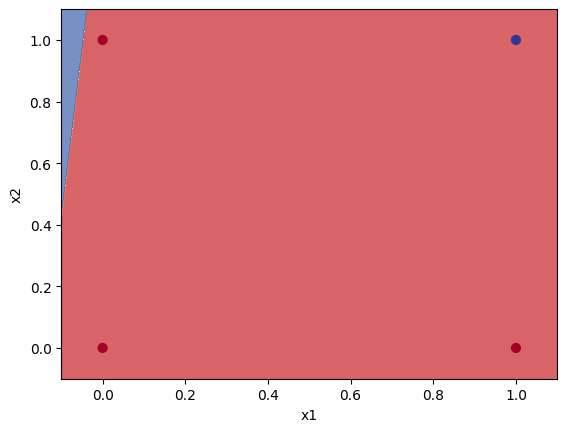

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7500 - loss: 0.7065
Epoch 101/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.7063
Epoch 102/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.7060
Epoch 103/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7057
Epoch 104/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.7054
Epoch 105/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.7051
Epoch 106/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.7048
Epoch 107/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.7046
Epoch 108/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.7043
Epoch 109/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7040
Epoch 110/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7037
Epoch 111/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - ac

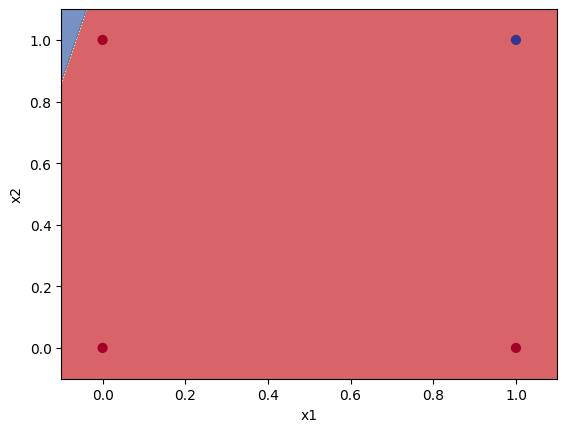

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7500 - loss: 0.6789
Epoch 201/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.6786
Epoch 202/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6784
Epoch 203/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6781
Epoch 204/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6778
Epoch 205/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.6776
Epoch 206/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7500 - loss: 0.6773
Epoch 207/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6770
Epoch 208/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6768
Epoch 209/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6765
Epoch 210/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6762
Epoch 211/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - ac

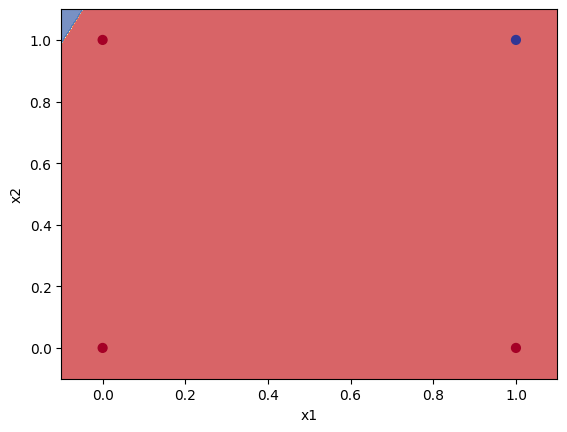

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7500 - loss: 0.6528
Epoch 301/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6526
Epoch 302/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6523
Epoch 303/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6521
Epoch 304/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.6518
Epoch 305/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6516
Epoch 306/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6513
Epoch 307/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6511
Epoch 308/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6508
Epoch 309/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6506
Epoch 310/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6503
Epoch 311/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - ac

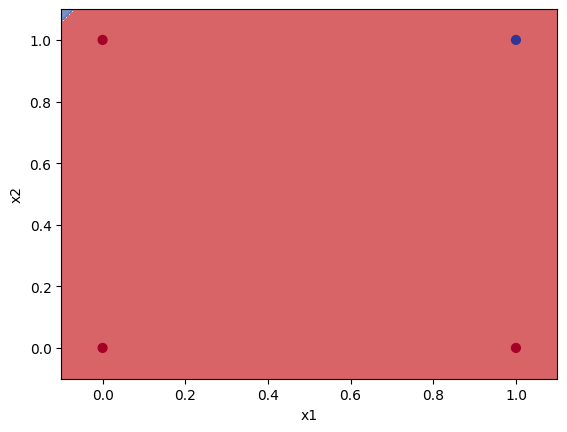

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7500 - loss: 0.6282
Epoch 401/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6280
Epoch 402/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6277
Epoch 403/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6275
Epoch 404/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6273
Epoch 405/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6270
Epoch 406/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6268
Epoch 407/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6266
Epoch 408/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6263
Epoch 409/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6261
Epoch 410/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6258
Epoch 411/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - ac

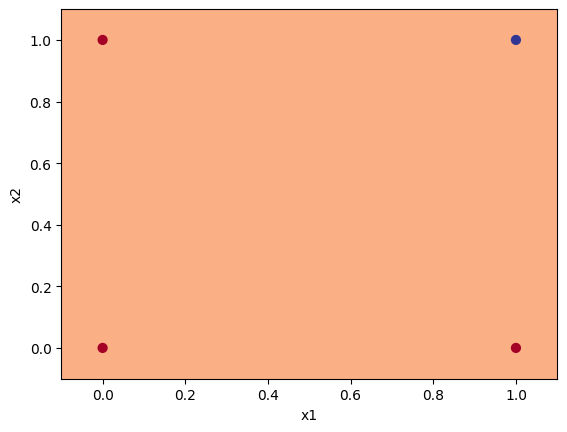

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7500 - loss: 0.6050
Epoch 501/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6048
Epoch 502/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6045
Epoch 503/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6043
Epoch 504/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.6041
Epoch 505/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7500 - loss: 0.6039
Epoch 506/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.6036
Epoch 507/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6034
Epoch 508/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.6032
Epoch 509/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6030
Epoch 510/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6027
Epoch 511/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - ac

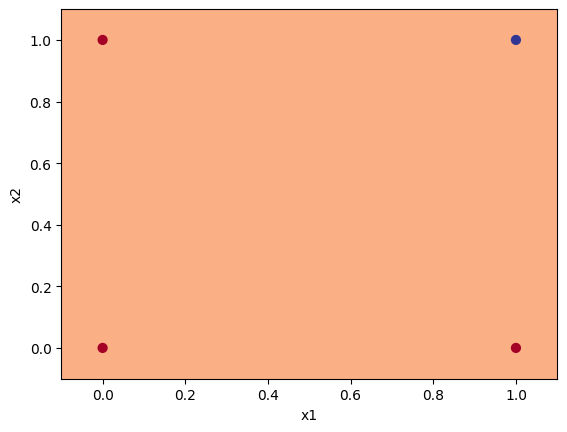

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7500 - loss: 0.5831
Epoch 601/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5828
Epoch 602/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5826
Epoch 603/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5824
Epoch 604/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5822
Epoch 605/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5820
Epoch 606/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5818
Epoch 607/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - loss: 0.5816
Epoch 608/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5814
Epoch 609/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7500 - loss: 0.5811
Epoch 610/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5809
Epoch 611/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - ac

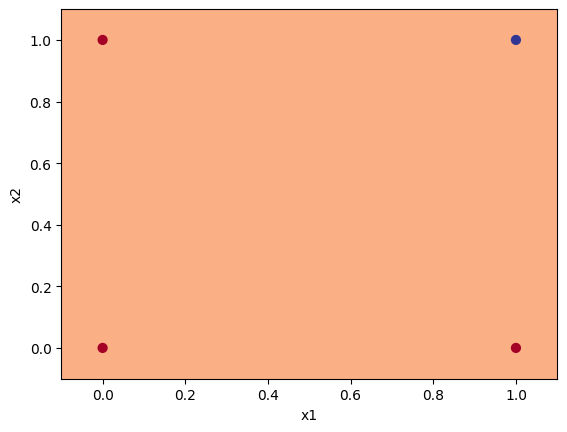

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7500 - loss: 0.5623
Epoch 701/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5621
Epoch 702/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.5619
Epoch 703/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5617
Epoch 704/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5615
Epoch 705/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5613
Epoch 706/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5611
Epoch 707/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5609
Epoch 708/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5607
Epoch 709/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5605
Epoch 710/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5603
Epoch 711/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - ac

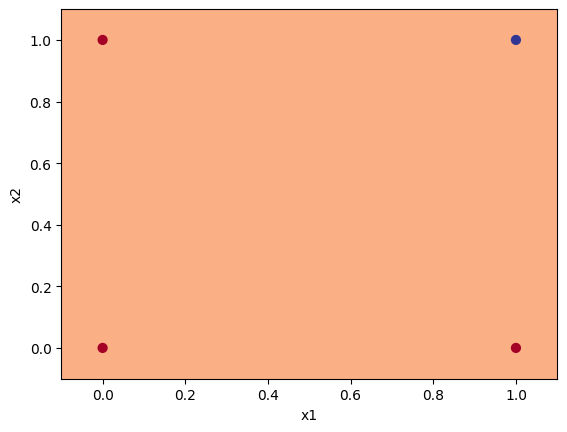

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7500 - loss: 0.5427
Epoch 801/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5425
Epoch 802/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.5423
Epoch 803/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5422
Epoch 804/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.5420
Epoch 805/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5418
Epoch 806/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.5416
Epoch 807/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.5414
Epoch 808/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5412
Epoch 809/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5410
Epoch 810/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.5408
Epoch 811/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - ac

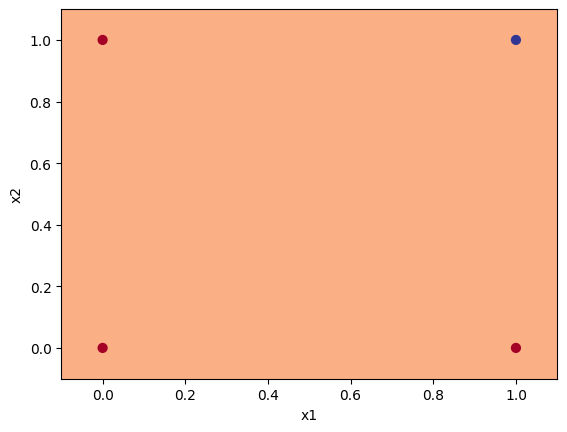

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7500 - loss: 0.5242
Epoch 901/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7500 - loss: 0.5240
Epoch 902/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5238
Epoch 903/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5236
Epoch 904/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5234
Epoch 905/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5233
Epoch 906/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5231
Epoch 907/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5229
Epoch 908/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5227
Epoch 909/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5225
Epoch 910/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5224
Epoch 911/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - a

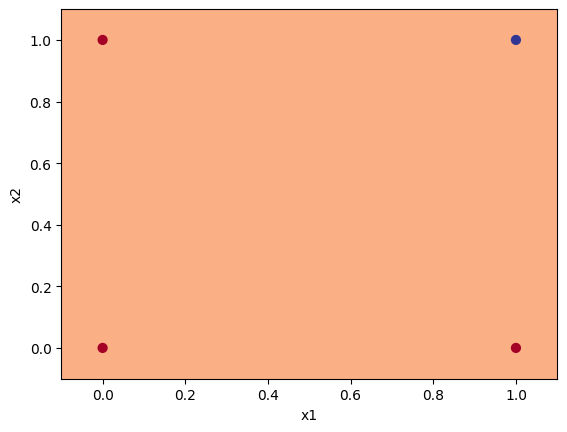

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7500 - loss: 0.5066
Epoch 1001/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5064
Epoch 1002/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5062
Epoch 1003/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5061
Epoch 1004/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5059
Epoch 1005/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5057
Epoch 1006/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5056
Epoch 1007/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5054
Epoch 1008/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5052
Epoch 1009/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5051
Epoch 1010/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5049
Epoch 1011/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23m

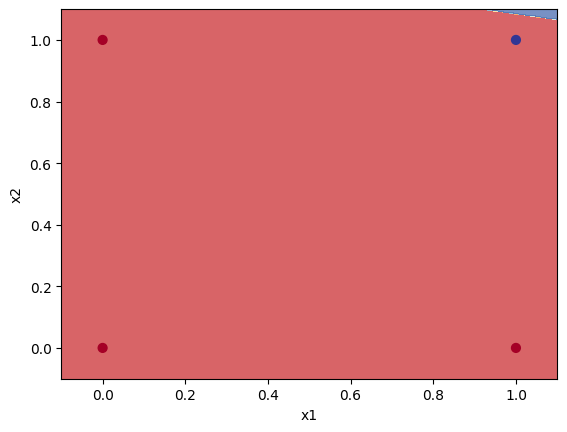

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.7500 - loss: 0.4899
Epoch 1101/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.4898
Epoch 1102/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.4896
Epoch 1103/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4894
Epoch 1104/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4893
Epoch 1105/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.4891
Epoch 1106/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4890
Epoch 1107/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.4888
Epoch 1108/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.4886
Epoch 1109/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.4885
Epoch 1110/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.4883
Epoch 1111/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

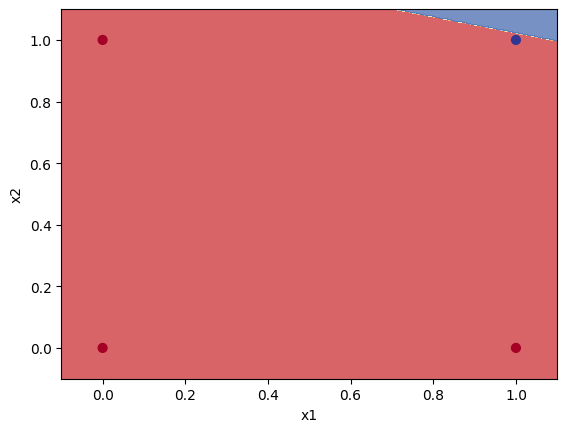

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7500 - loss: 0.4741
Epoch 1201/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4740
Epoch 1202/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4738
Epoch 1203/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4736
Epoch 1204/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4735
Epoch 1205/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4733
Epoch 1206/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4732
Epoch 1207/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4730
Epoch 1208/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4729
Epoch 1209/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4727
Epoch 1210/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4726
Epoch 1211/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

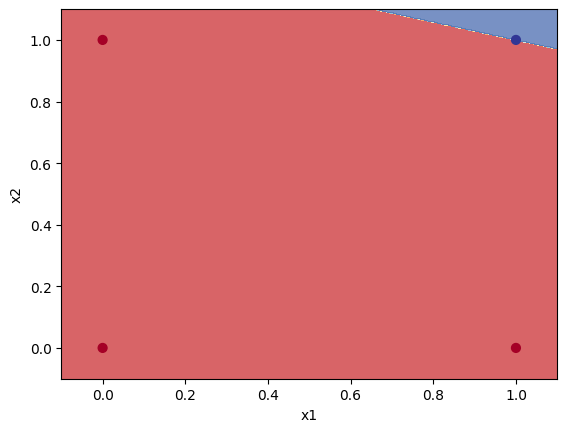

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 1.0000 - loss: 0.4675


In [17]:
model = trainModel(X, Y) # вызов обучения модели

In [18]:
input_data = np.array([[1, 1]])
testModel(input_data, model) # вызов тестирования обученной модели на тестовых данных

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.50014704]]


1

In [19]:
# Получить веса нейрона
model.get_weights()

[array([[0.26511714],
        [0.911034  ]], dtype=float32),
 array([-1.175563], dtype=float32)]

# **Построение графика активационной функции**

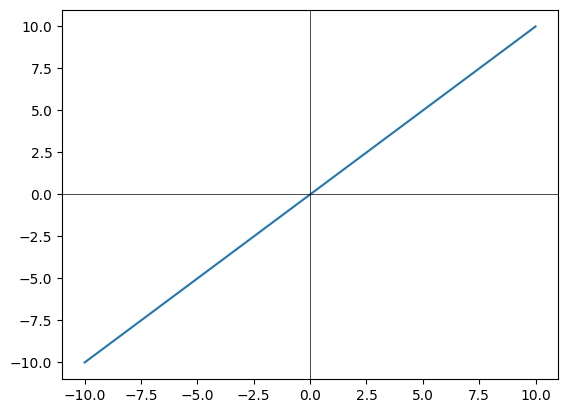

In [20]:
# Пример линейной функции f(x) = x
def linear_function(x):
  return x

act_x = np.linspace(-10, 10, 101) # генерация чисел с диапазоном от -10 до 10 с равномерным интервалом. Всего 101 число с учётом 0.
act_y = [linear_function(x) for x in act_x] # вычисление значения функции в каждой точке созданного act_x

plt.plot(act_x, act_y) # построение графика функции активации
# Добавление осей x и y
plt.axhline(0, color='black',linewidth=0.5)  # Горизонтальная ось (ось x)
plt.axvline(0, color='black',linewidth=0.5)  # Вертикальная ось (ось y)
plt.show() # показ графика